# Tutorial 3

In this tutorial, we'll look at overfitting and methods of preventing it.

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

print("Torch version:", torch.__version__)

Torch version: 2.8.0+cu128


## Neural network training and overfitting

In [2]:
batch_size = 64

In [3]:
data_train = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)
data_test = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

data_train, data_val = torch.utils.data.random_split(data_train, [50000, 10000])

dataloader_train = DataLoader(data_train, batch_size = batch_size, shuffle = True)
dataloader_val = DataLoader(data_val, batch_size = batch_size, shuffle = True)
dataloader_test = DataLoader(data_test, batch_size = batch_size, shuffle = True)

In [4]:
model = nn.Sequential()
model.append(nn.Flatten())
model.append(nn.Linear(data_train.dataset.data.shape[1] * data_train.dataset.data.shape[2], 512))
model.append(nn.ReLU())
model.append(nn.Linear(512, 512))
model.append(nn.ReLU())
model.append(nn.Linear(512, 256))
model.append(nn.ReLU())
model.append(nn.Linear(256, 10))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=10, bias=True)
)

In [5]:
def calculate_loss(model, dataloader, loss_fn):
    loss = 0
    
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()

    loss /= len(dataloader)
    return loss

In [6]:
def calculate_accuracy(model, dataloader):
    num_correct = 0
    
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = num_correct / len(dataloader.dataset)
    return accuracy

In [7]:
def calculate_loss_accuracy(model, dataloader, loss_fn):
    loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= len(dataloader)
    accuracy = num_correct / len(dataloader.dataset)
    return loss, accuracy

In [8]:
def train_model(model, loss_fn, optimizer, epochs, dataloader_train, dataloader_val, dataloader_test, early_stopper = None, log_period = 10000):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        processed_since_log = 0
        for batch, (X, y) in enumerate(dataloader_train):
            model.train()
            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            processed_since_log += dataloader_train.batch_size

            if processed_since_log >= log_period:
                current = min((batch + 1) * dataloader_train.batch_size, len(data_train))
                loss = loss.item()
                model.eval()
                train_acc = calculate_accuracy(model, dataloader_train)
                test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, loss_fn)
                train_losses.append(loss)
                test_losses.append(test_loss)
                train_accuracies.append(train_acc)
                test_accuracies.append(test_acc)
                print(f"train loss: {loss:>7f}  test loss: {test_loss:>7f}  train accuracy: {train_acc:>3f}  test accuracy: {test_acc:>3f}  [sample {current:>5d}/{len(data_train):>5d}] [epoch {epoch+1:>2d}/{epochs:>2d}]")
                processed_since_log -= log_period

        if early_stopper is not None and early_stopper.early_stop(calculate_loss(model, dataloader_val, loss_fn)):             
                break
            
    return train_losses, test_losses, train_accuracies, test_accuracies

In [9]:
train_losses, test_losses, _, _ = train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters()), 40, dataloader_train, dataloader_val, dataloader_test, None)

train loss: 0.448134  test loss: 0.270487  train accuracy: 0.918280  test accuracy: 0.917800  [sample 10048/50000] [epoch  1/40]
train loss: 0.430929  test loss: 0.180003  train accuracy: 0.944280  test accuracy: 0.947500  [sample 20032/50000] [epoch  1/40]
train loss: 0.113221  test loss: 0.150636  train accuracy: 0.955340  test accuracy: 0.954700  [sample 30016/50000] [epoch  1/40]
train loss: 0.116881  test loss: 0.134964  train accuracy: 0.959820  test accuracy: 0.957700  [sample 40000/50000] [epoch  1/40]
train loss: 0.024164  test loss: 0.176285  train accuracy: 0.955720  test accuracy: 0.946800  [sample 50000/50000] [epoch  1/40]
train loss: 0.204268  test loss: 0.106716  train accuracy: 0.973960  test accuracy: 0.966400  [sample 10048/50000] [epoch  2/40]
train loss: 0.019699  test loss: 0.131430  train accuracy: 0.968240  test accuracy: 0.960800  [sample 20032/50000] [epoch  2/40]
train loss: 0.076821  test loss: 0.112412  train accuracy: 0.974600  test accuracy: 0.965300  [sa

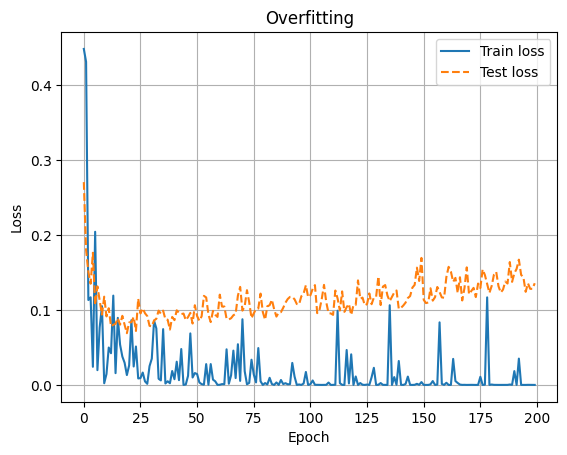

In [10]:
plt.figure()
plt.grid(True)
plt.plot(train_losses, label = "Train loss")
plt.plot(test_losses, '--', label = "Test loss")
plt.title("Overfitting")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

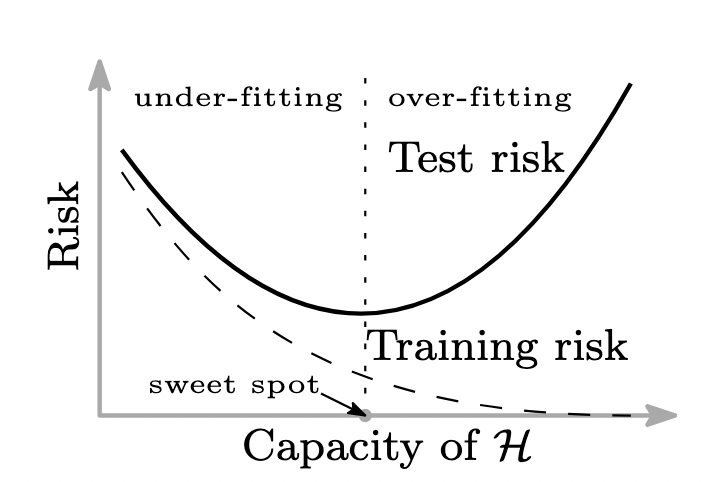

*BELKIN, Mikhail, HSU, Daniel, MA, Siyuan and MANDAL, Soumik, 2019. Reconciling modern machine-learning practice and the classical bias–variance trade-off. Proceedings of the National Academy of Sciences. 6 August 2019. Vol. 116, no. 32, p. 15849–15854. DOI 10.1073/pnas.1903070116.*

# Regularization

Neural networks have a tendency to overfit due to their large number of parameters. To fix this issue, we can use a range of *regularization* techniques. Let us show four of them.

### Training in mini-batches

Neural networks are most often trained using gradient descent (in some exceptions, second derivatives are used as well through the Hessian of the obejctive function).

The typical approach is not to do gradient descent with respect to the average loss $J$ over the whole dataset, but to make smaller samples from the dataset and average the loss only over them. The most used approach is to make this sample "deterministic" in the sense that we take the original dataset, *shuffle* it, and then divide it into so-called *mini-batches*, which we use to calculate the average $J$ in each step of gradient descent.

As we probably remember from statistics, the mean is a good point estimator of the expected value and its variance decreases with the size of the sample - the variance is $1/\sqrt{n}$, where $n$ is the sample size. Due to this, by decreasing the batch sizes, we increase the random noise in the estimation of the true loss function and through this, the random noise in the gradients as well.

However, batch sizes do not only affect this, in fact, the affect a whole range of aspects of training (see chapter 8.1.3 in the [Deep Learning book](https://www.deeplearningbook.org/contents/optimization.html)):
- Bigger batches give a more precise estimation of the gradient (with a non-linear dependency on the batch size)
- Multi-core and multi-thread processing units are suboptimally used with small batch sizes
- If the samples from a batch are processed in parallel (which they usually are), the memory requirements grow with the batch size
- On a GPU, it's typically advantageous to have batch sizes be powers of 2
- Small batch sizes have a *regularization* effect - most probably due to the random noise they inject into the training
- Small batch sizes work fine with optimizers using just the gradient (i.e., the first derivative). However, for optimisers which use the Hessian (i.e., the second derivative), small batch sizes are problematic. Such optimizers usually calculate the inverse of the Hessian, which can be very sensitive to precision.

In [11]:
def train_batch_model(batch_size):
    model = nn.Sequential()
    model.append(nn.Flatten())
    model.append(nn.Linear(data_train.dataset.data.shape[1] * data_train.dataset.data.shape[2], 512))
    model.append(nn.ReLU())
    model.append(nn.Linear(512, 10))
    
    return train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters()), 20, DataLoader(data_train, batch_size, shuffle = True), DataLoader(data_val, batch_size, shuffle = True), DataLoader(data_test, batch_size, shuffle = True))

batch_sizes = [16, 32, 64, 128, 256, 512]
histories = [train_batch_model(i) for i in batch_sizes]

train loss: 0.322269  test loss: 0.286149  train accuracy: 0.916120  test accuracy: 0.916200  [sample 10000/50000] [epoch  1/20]
train loss: 0.408220  test loss: 0.178779  train accuracy: 0.947460  test accuracy: 0.942100  [sample 20000/50000] [epoch  1/20]
train loss: 0.064390  test loss: 0.139175  train accuracy: 0.962160  test accuracy: 0.957400  [sample 30000/50000] [epoch  1/20]
train loss: 0.154672  test loss: 0.115025  train accuracy: 0.968500  test accuracy: 0.963400  [sample 40000/50000] [epoch  1/20]
train loss: 0.047610  test loss: 0.111930  train accuracy: 0.970420  test accuracy: 0.966300  [sample 50000/50000] [epoch  1/20]
train loss: 0.049993  test loss: 0.101805  train accuracy: 0.972040  test accuracy: 0.970200  [sample 10000/50000] [epoch  2/20]
train loss: 0.003331  test loss: 0.094696  train accuracy: 0.975100  test accuracy: 0.970500  [sample 20000/50000] [epoch  2/20]
train loss: 0.030385  test loss: 0.098638  train accuracy: 0.975680  test accuracy: 0.969000  [sa

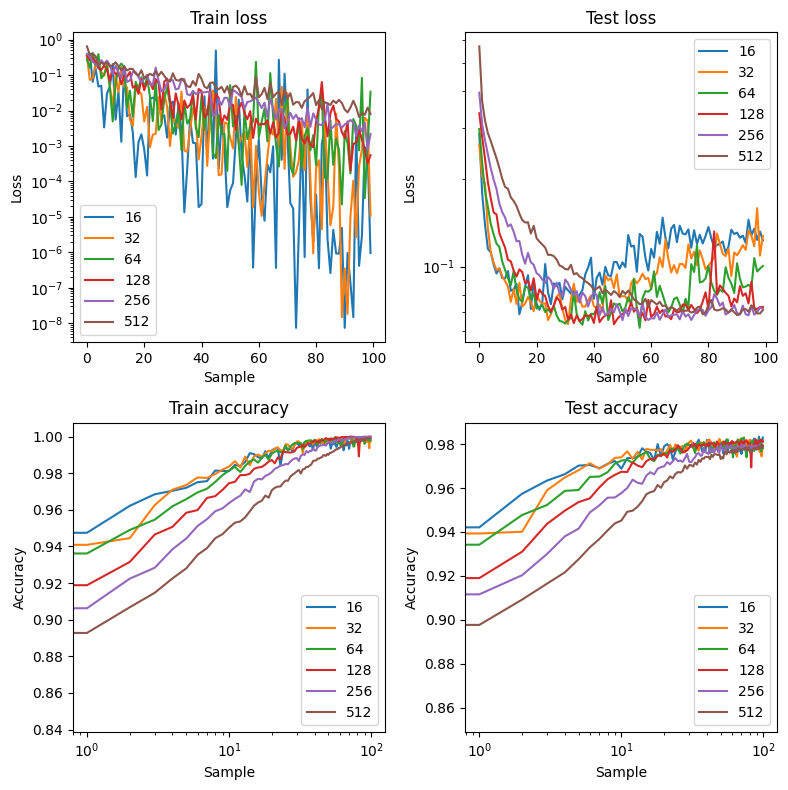

In [12]:
fig, axs = plt.subplots(2, 2, figsize = (8, 8))
    
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')

axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

for i in range(len(batch_sizes)):
    axs[0, 0].plot(histories[i][0], '-', label = batch_sizes[i])
    axs[0, 1].plot(histories[i][1], '-', label = batch_sizes[i])
    axs[1, 0].plot(histories[i][2], '-', label = batch_sizes[i])
    axs[1, 1].plot(histories[i][3], '-', label = batch_sizes[i])

axs[0, 0].set_title("Train loss")
axs[0, 0].set_xlabel("Sample")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 1].set_title("Test loss")
axs[0, 1].set_xlabel("Sample")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
axs[1, 0].set_title("Train accuracy")
axs[1, 0].set_xlabel("Sample")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()
axs[1, 1].set_title("Test accuracy")
axs[1, 1].set_xlabel("Sample")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()

fig.tight_layout()

### Early stopping

We can prevent overfitting by just stopping the training before overfitting happens. We use the *training set* to optimize the model. Apart from that, after each epoch, we calculate the value of the loss function on a *validation set*. Once this value starts rising, it means the model is starting to overfit and we can stop the training.

Due to randomness, it's better to wait for a few epochs of rising validation set loss values - otherwise, it could just be a local increase, followed by a new decrease in the loss value and we would stop the training prematurely.

In [13]:
dataloader_train = DataLoader(data_train, batch_size = 64, shuffle = True)

In [14]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [15]:
model = nn.Sequential()
model.append(nn.Flatten())
model.append(nn.Linear(data_train.dataset.data.shape[1] * data_train.dataset.data.shape[2], 512))
model.append(nn.ReLU())
model.append(nn.Linear(512, 10))
train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters()), 20, dataloader_train, dataloader_val, dataloader_test, EarlyStopper());

train loss: 0.241231  test loss: 0.294261  train accuracy: 0.913040  test accuracy: 0.915400  [sample 10048/50000] [epoch  1/20]
train loss: 0.130303  test loss: 0.236744  train accuracy: 0.930420  test accuracy: 0.930000  [sample 20032/50000] [epoch  1/20]
train loss: 0.229830  test loss: 0.193247  train accuracy: 0.946220  test accuracy: 0.943300  [sample 30016/50000] [epoch  1/20]
train loss: 0.312429  test loss: 0.150571  train accuracy: 0.958060  test accuracy: 0.954000  [sample 40000/50000] [epoch  1/20]
train loss: 0.339736  test loss: 0.148177  train accuracy: 0.958740  test accuracy: 0.956500  [sample 50000/50000] [epoch  1/20]
train loss: 0.242870  test loss: 0.132534  train accuracy: 0.964120  test accuracy: 0.959300  [sample 10048/50000] [epoch  2/20]
train loss: 0.114708  test loss: 0.120050  train accuracy: 0.969940  test accuracy: 0.964200  [sample 20032/50000] [epoch  2/20]
train loss: 0.182507  test loss: 0.109230  train accuracy: 0.971720  test accuracy: 0.966200  [sa

In [16]:
test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, nn.CrossEntropyLoss())
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.08580633167364296
Test accuracy: 0.9767


### L1 and L2 regularization

This kind of regularization replaces the loss value $J$ with $J + \alpha \cdot \sum_i \lvert w_i\rvert^p$, where $p = 1$ for $L^1$ regularization or $p = 2$ for $L^2$ regularization.

L1 and L2 regularization can be applied to each layer independently. It lowers the variance of weights at the cost of higher bias. See [bias-variance trade-off](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

In [17]:
model = nn.Sequential()
model.append(nn.Flatten())
model.append(nn.Linear(data_train.dataset.data.shape[1] * data_train.dataset.data.shape[2], 512))
model.append(nn.ReLU())
model.append(nn.Linear(512, 10))
train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters()), 20, dataloader_train, dataloader_val, dataloader_test);

train loss: 0.262930  test loss: 0.324395  train accuracy: 0.904680  test accuracy: 0.907700  [sample 10048/50000] [epoch  1/20]
train loss: 0.219857  test loss: 0.234245  train accuracy: 0.931020  test accuracy: 0.931300  [sample 20032/50000] [epoch  1/20]
train loss: 0.207793  test loss: 0.195139  train accuracy: 0.944600  test accuracy: 0.941000  [sample 30016/50000] [epoch  1/20]
train loss: 0.143923  test loss: 0.166207  train accuracy: 0.954720  test accuracy: 0.951000  [sample 40000/50000] [epoch  1/20]
train loss: 0.041580  test loss: 0.144297  train accuracy: 0.962240  test accuracy: 0.955400  [sample 50000/50000] [epoch  1/20]
train loss: 0.096658  test loss: 0.133746  train accuracy: 0.964360  test accuracy: 0.959600  [sample 10048/50000] [epoch  2/20]
train loss: 0.040217  test loss: 0.119282  train accuracy: 0.971280  test accuracy: 0.964100  [sample 20032/50000] [epoch  2/20]
train loss: 0.076322  test loss: 0.106927  train accuracy: 0.974880  test accuracy: 0.966700  [sa

In [18]:
test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, nn.CrossEntropyLoss())
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.10090741158498653
Test accuracy: 0.9794


### Dropout

Dropout randomly zeroes-out neurons in the layer it's applied to. In each iteration, we randomly select neurons (each neuron makes an independent weighted coin flip), which are removed together with all their connections.

In essesnce, randomly disabling inputs of different neural network layers forces the neural net to use a broader range of information from the previous layer, preventing it from relying too much on any individual signal.

For a more detailed mathematical description, see [here](https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275). An interesting observation is that dropout for linear regression is equivalent to L2 regularization.

As a hyper-parameter for dropout we typically give the probability $p$ of disabling each individual neuron. When making an test-time inference, we don't disable any neurons (since we want to get the best performance), but to preserve the magnitudes of layer outputs, we use a *weight scaling rule*, where we multiply the trained weights of the neural network by $(1-p)$, which offsets the fact that we hacve more nbeurons compared to trainign. In PyTorch, the implementation actually keeps the neurons as-is during inference and multiplies the non-disabled neurons by $1/(1-p)$ during training, achieving the same effect. 

Dropout is a very effective regularization technique and is computationally rather simple.

In [19]:
model = nn.Sequential()
model.append(nn.Flatten())
model.append(nn.Dropout(0.5))
model.append(nn.Linear(data_train.dataset.data.shape[1] * data_train.dataset.data.shape[2], 512))
model.append(nn.ReLU())
model.append(nn.Dropout(0.3))
model.append(nn.Linear(512, 10))
train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters()), 20, dataloader_train, dataloader_val, dataloader_test, EarlyStopper());

train loss: 0.418792  test loss: 0.361928  train accuracy: 0.889760  test accuracy: 0.897600  [sample 10048/50000] [epoch  1/20]
train loss: 0.598491  test loss: 0.275480  train accuracy: 0.919280  test accuracy: 0.924300  [sample 20032/50000] [epoch  1/20]
train loss: 0.458937  test loss: 0.231160  train accuracy: 0.933760  test accuracy: 0.934900  [sample 30016/50000] [epoch  1/20]
train loss: 0.402882  test loss: 0.211605  train accuracy: 0.939940  test accuracy: 0.941900  [sample 40000/50000] [epoch  1/20]
train loss: 0.217276  test loss: 0.187307  train accuracy: 0.947180  test accuracy: 0.947100  [sample 50000/50000] [epoch  1/20]
train loss: 0.214739  test loss: 0.159185  train accuracy: 0.955480  test accuracy: 0.952800  [sample 10048/50000] [epoch  2/20]
train loss: 0.303898  test loss: 0.148916  train accuracy: 0.957960  test accuracy: 0.957200  [sample 20032/50000] [epoch  2/20]
train loss: 0.258186  test loss: 0.137502  train accuracy: 0.962400  test accuracy: 0.959500  [sa

In [20]:
test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, nn.CrossEntropyLoss())
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.0646677923479242
Test accuracy: 0.9802


### Batch Normalization

In batch normalization, we normalize the outputs of individual model layers. The normalization parameters - the mean and the variance - are estimated from the batches. Typically, this improves training ability. During test-time inference, we usually use the mean and the variance of the last few batches from the training.

In [21]:
model = nn.Sequential()
model.append(nn.Flatten())
model.append(nn.BatchNorm1d(data_train.dataset.data.shape[1] * data_train.dataset.data.shape[2]))
model.append(nn.Linear(data_train.dataset.data.shape[1] * data_train. dataset.data.shape[2], 512))
model.append(nn.ReLU())
model.append(nn.Linear(512, 10))
train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters()), 20, dataloader_train, dataloader_val, dataloader_test, EarlyStopper());

train loss: 0.202324  test loss: 0.249967  train accuracy: 0.931280  test accuracy: 0.932200  [sample 10048/50000] [epoch  1/20]
train loss: 0.137837  test loss: 0.205100  train accuracy: 0.953040  test accuracy: 0.949700  [sample 20032/50000] [epoch  1/20]
train loss: 0.164096  test loss: 0.221871  train accuracy: 0.957220  test accuracy: 0.951400  [sample 30016/50000] [epoch  1/20]
train loss: 0.093170  test loss: 0.213081  train accuracy: 0.963440  test accuracy: 0.955600  [sample 40000/50000] [epoch  1/20]
train loss: 0.333898  test loss: 0.251691  train accuracy: 0.969820  test accuracy: 0.959400  [sample 50000/50000] [epoch  1/20]
train loss: 0.131164  test loss: 0.214533  train accuracy: 0.973020  test accuracy: 0.964200  [sample 10048/50000] [epoch  2/20]
train loss: 0.128047  test loss: 0.226033  train accuracy: 0.975480  test accuracy: 0.964300  [sample 20032/50000] [epoch  2/20]
train loss: 0.073298  test loss: 0.219660  train accuracy: 0.977120  test accuracy: 0.967100  [sa

In [22]:
test_loss, test_acc = calculate_loss_accuracy(model, dataloader_test, nn.CrossEntropyLoss())
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.46072517826954484
Test accuracy: 0.9688


## Double descent

Overfitting as described above is a function of the model capacity (~parameter count) and the training time. In modern ML, we can, however, encounter a *double-descent* effect as well - see an example on the MNIST dataset:

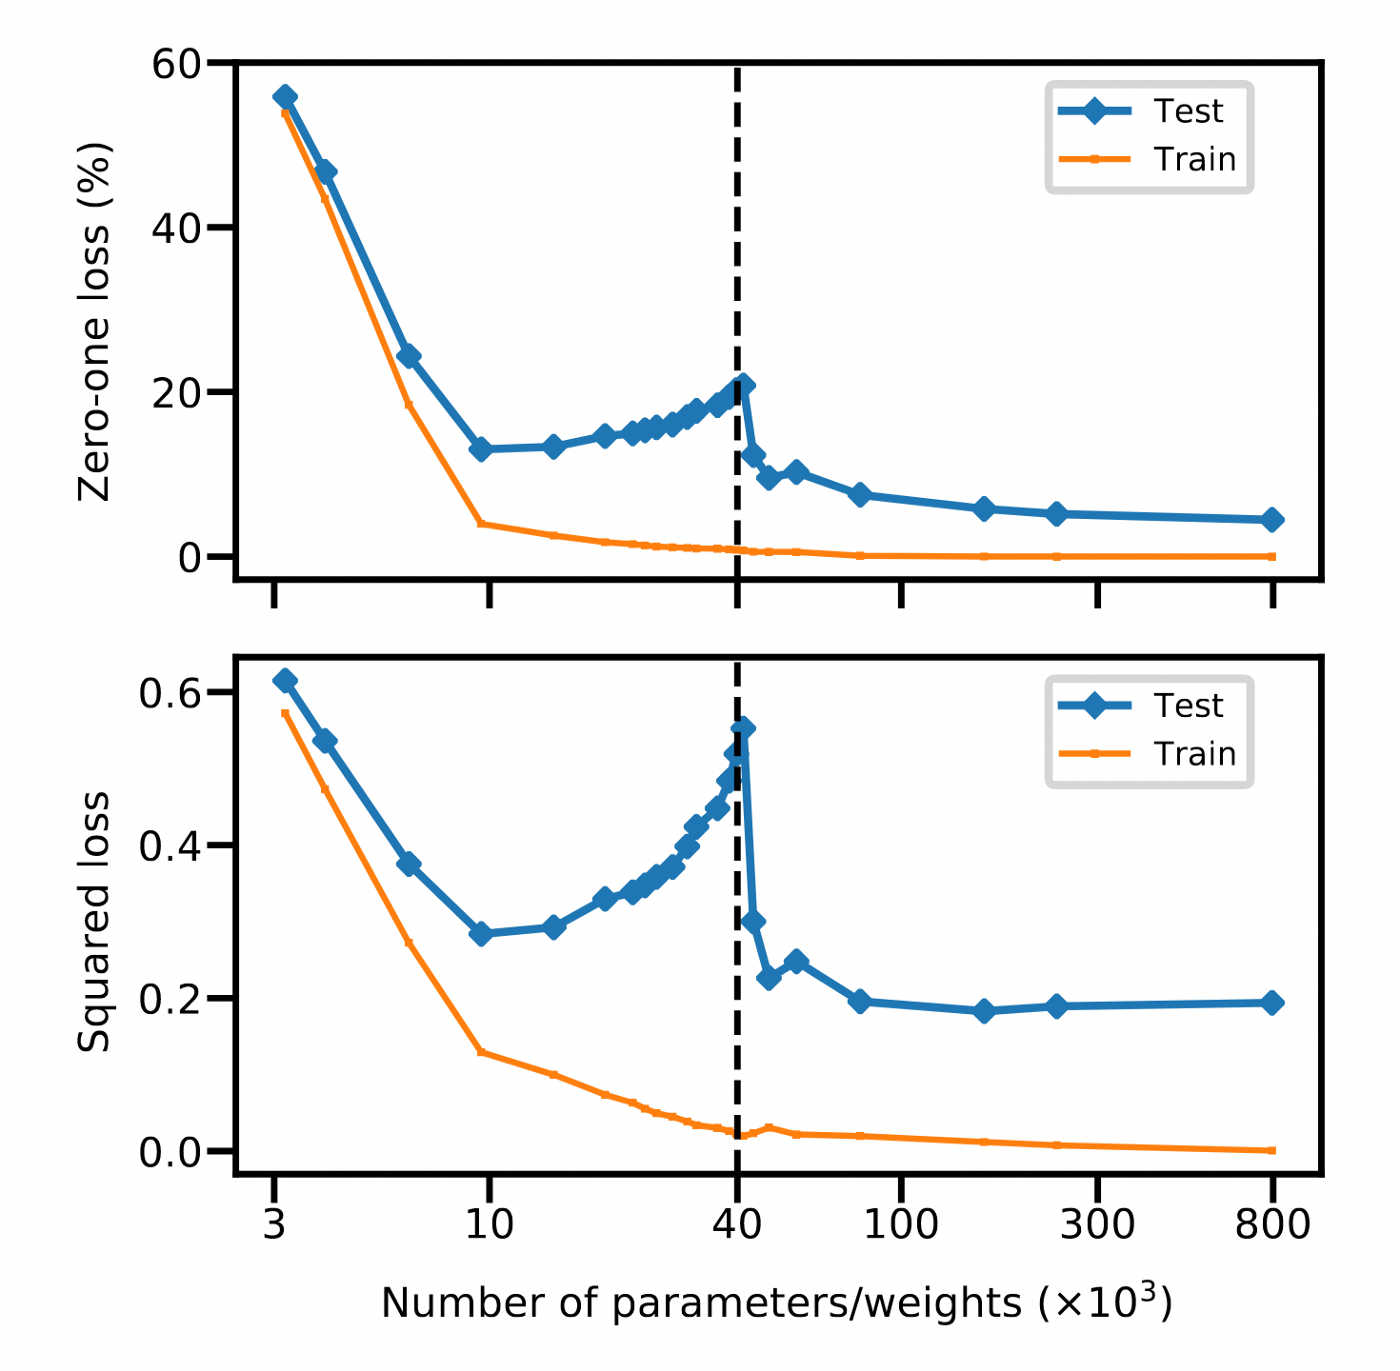

*BELKIN, Mikhail, HSU, Daniel, MA, Siyuan and MANDAL, Soumik, 2019. Reconciling modern machine-learning practice and the classical bias–variance trade-off. Proceedings of the National Academy of Sciences. 6 August 2019. Vol. 116, no. 32, p. 15849–15854. DOI 10.1073/pnas.1903070116.*

More generally, we describe two regimes of the model behaviour depending on the model capacity. In the "classical" regime, we can see the model overfitting with high parameter counts. On the other hand, in the "interpolation regime", increasing the model capacity leads to an improvement of both training and test error.

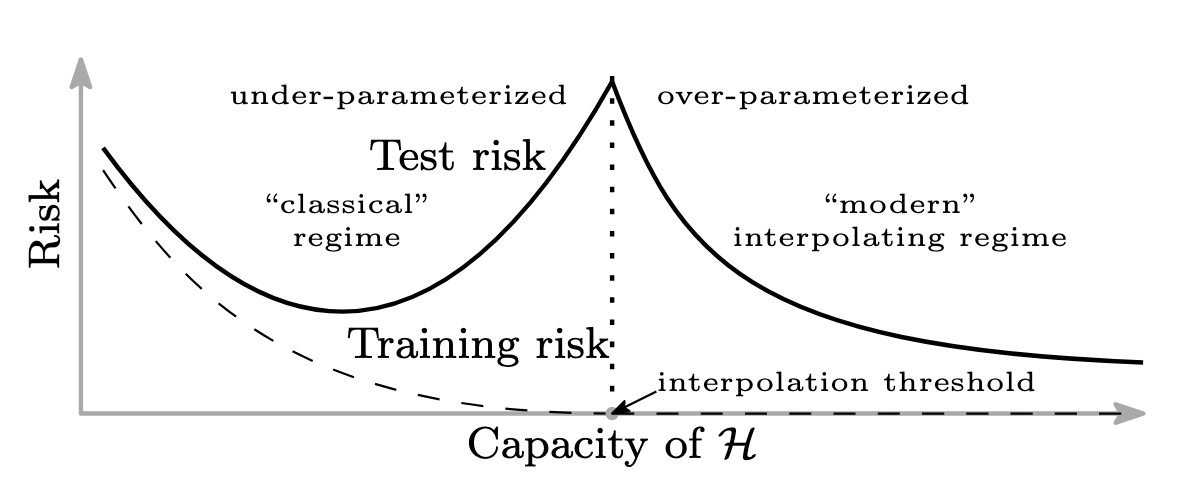

*BELKIN, Mikhail, HSU, Daniel, MA, Siyuan and MANDAL, Soumik, 2019. Reconciling modern machine-learning practice and the classical bias–variance trade-off. Proceedings of the National Academy of Sciences. 6 August 2019. Vol. 116, no. 32, p. 15849–15854. DOI 10.1073/pnas.1903070116.*

This behaviour is a function of not only model capacity, but also training time:

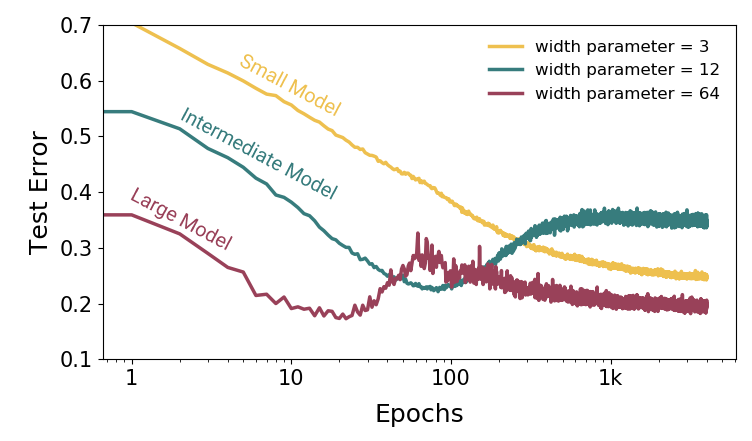
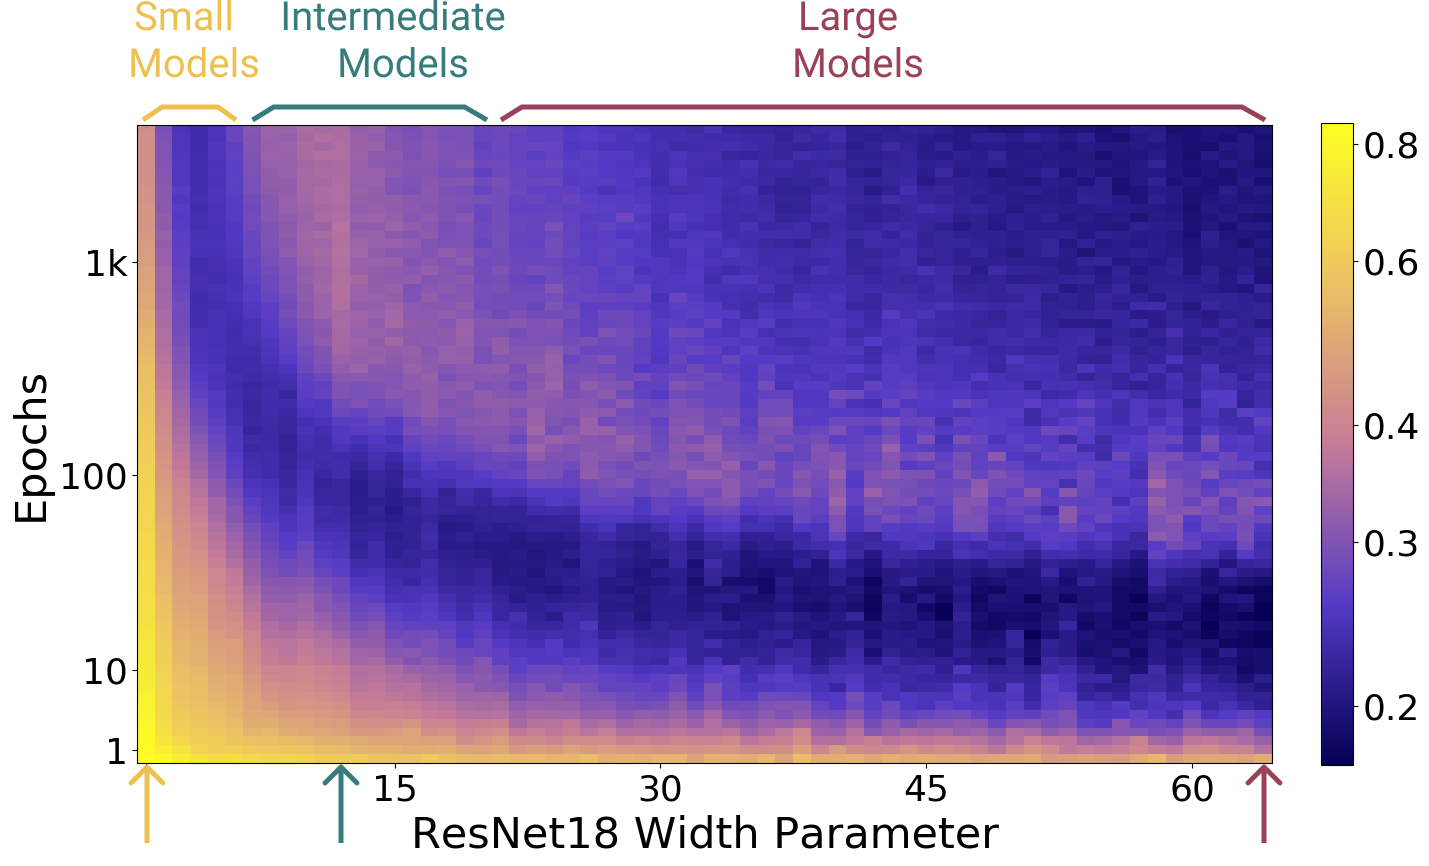

*NAKKIRAN, Preetum, KAPLUN, Gal, BANSAL, Yamini, YANG, Tristan, BARAK, Boaz and SUTSKEVER, Ilya, 2021. Deep double descent: where bigger models and more data hurt\ast. Journal of Statistical Mechanics: Theory and Experiment. December 2021. Vol. 2021, no. 12, p. 124003. DOI 10.1088/1742-5468/ac3a74.*